In [ ]:
!pip install nussl scaper

In [3]:
import nussl
import scaper
from IPython.display import Audio, display
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# These two libraries are from https://github.com/source-separation/tutorial 
# from common import data
# from common import viz
from nussl.datasets import transforms as nussl_tfm

dataset_path = "~/userdata/datasets/musdb"


## 1. Load dataset

In [7]:
dataset_path = "~/userdata/dataset/musdb"
musdb_train = nussl.datasets.MUSDB18(dataset_path, subsets='train', split="train")
musdb_valid = nussl.datasets.MUSDB18(dataset_path, subsets='train', split="valid")
musdb_test = nussl.datasets.MUSDB18(dataset_path, subsets='test')
len(musdb_train), len(musdb_valid), len(musdb_test)

(86, 14, 50)

In [8]:
train_item = musdb_train[0]

In [9]:
train_item['mix'].audio_data

array([[1.47705078e-02, 3.26538086e-02, 5.39550781e-02, ...,
        0.00000000e+00, 3.05175781e-05, 0.00000000e+00],
       [3.02124023e-03, 1.63879395e-02, 3.79028320e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [10]:
train_item['mix'].audio_data.shape

(2, 7552000)

In [11]:
train_item['sources']

{'drums': <nussl.core.audio_signal.AudioSignal at 0x7fafe93e8340>,
 'bass': <nussl.core.audio_signal.AudioSignal at 0x7fafe93e80d0>,
 'other': <nussl.core.audio_signal.AudioSignal at 0x7fafe93e81f0>,
 'vocals': <nussl.core.audio_signal.AudioSignal at 0x7fafe95bfa90>}

In [13]:
train_item['sources']['vocals'].audio_data

array([[0.01608276, 0.02474976, 0.03643799, ..., 0.        , 0.        ,
        0.        ],
       [0.00808716, 0.01702881, 0.03375244, ..., 0.        , 0.        ,
        0.        ]])

In [14]:
# Dataset is usually subscriptable,
display(Audio(musdb_train[0]['mix'].audio_data[:, :200000], rate=44100))

In [15]:
display(Audio(train_item['sources']['vocals'].audio_data[:, :200000], rate=44100))

In [5]:
# This function is a modified version of tutorial.common.data.prepare_data
# It will split the STEM audio file into each source and split
for i, musdb in enumerate([musdb_train, musdb_valid, musdb_test]):
  _folder = Path(dataset_path) / ["train", "valid", "test"][i]
  _folder = _folder.expanduser()
  _folder.mkdir(exist_ok=True)
  for item in tqdm.tqdm(musdb):
    song_name = item['mix'].file_name
    for key, val in item['sources'].items():
      src_path = _folder / key 
      src_path.mkdir(exist_ok=True)
      src_path = str(src_path / song_name) + '.wav'
      val.write_audio_to_file(src_path)


FileNotFoundError: [Errno 2] No such file or directory: '/home/teo/userdata/datasets/musdb/train'

In [35]:
# data.on_the_fly makes a new mixture from source
from common import data
from common import viz

stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
duration = 10

trainset = data.on_the_fly(stft_params, transform=None, fg_path=dataset_path+"/train", num_mixtures=100000, duration=duration)
item = trainset[200]
# viz.show_sources(item['sources'])

In [23]:
len(trainset)

100000

In [36]:
display(Audio(item['mix'].audio_data[:, :200000], rate=44100))

In [ ]:
??data.on_the_fly

In [ ]:
len(trainset)

In [32]:
print(item['metadata']['jam']["annotations"][0]["data"])

SortedKeyList([Observation(time=0.0, duration=6.8034467120181406, value={'label': 'vocals', 'source_file': '/home/teo/userdata/dataset/musdb/train/vocals/Auctioneer - Our Future Faces.wav', 'source_time': 0, 'event_time': 0, 'event_duration': 6.8034467120181406, 'snr': 1.2356369678597234, 'role': 'foreground', 'pitch_shift': None, 'time_stretch': None}, confidence=1.0), Observation(time=0.0, duration=6.8034467120181406, value={'label': 'drums', 'source_file': '/home/teo/userdata/dataset/musdb/train/drums/James May - If You Say.wav', 'source_time': 0, 'event_time': 0, 'event_duration': 6.8034467120181406, 'snr': -2.0246539345552774, 'role': 'foreground', 'pitch_shift': None, 'time_stretch': None}, confidence=1.0), Observation(time=0.0, duration=6.8034467120181406, value={'label': 'bass', 'source_file': '/home/teo/userdata/dataset/musdb/train/bass/Bill Chudziak - Children Of No-one.wav', 'source_time': 0, 'event_time': 0, 'event_duration': 6.8034467120181406, 'snr': -1.1655848117422227, 

In [37]:
print(item)
print(item.keys())

{'mix': <nussl.core.audio_signal.AudioSignal object at 0x7fafe431a700>, 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal object at 0x7fafe422be80>, 'drums': <nussl.core.audio_signal.AudioSignal object at 0x7fafe422b910>, 'bass': <nussl.core.audio_signal.AudioSignal object at 0x7fafe422bb50>, 'other': <nussl.core.audio_signal.AudioSignal object at 0x7fafe422bfd0>}, 'metadata': {'jam': <JAMS(file_metadata=<FileMetadata(...)>,
      annotations=[1 annotation],
      sandbox=<Sandbox(...)>)>, 'idx': 200}}
dict_keys(['mix', 'sources', 'metadata'])


In [ ]:
item

### Transform Data
- We have to transform nussl.core.AudioSignal into desired format
    1. We want to make One Vs All separation system. Therefore, we have to combine the sources except target
        - If you want to make vocal separator, you can mix drum, bass, and other as a single source
        - If you want to make drum separator, you can mix vocal, bass, and other as a single source
    2. We want to use spectrogram instead of waveform audio samples 


In [39]:
from nussl.datasets import transforms as nussl_tfm

item = trainset[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
transformed_item = sum_sources(item)
print(transformed_item['sources'])
# viz.show_sources(transformed_item['sources'])

{'vocals': <nussl.core.audio_signal.AudioSignal object at 0x7fafe8dfd9d0>, 'bass+drums+other': <nussl.core.audio_signal.AudioSignal object at 0x7fafe431a1c0>}


In [44]:
item['sources']

OrderedDict([('bass', <nussl.core.audio_signal.AudioSignal at 0x7fafe4121fd0>),
             ('drums',
              <nussl.core.audio_signal.AudioSignal at 0x7fafe4121f10>),
             ('other',
              <nussl.core.audio_signal.AudioSignal at 0x7fafe4121e80>),
             ('vocals',
              <nussl.core.audio_signal.AudioSignal at 0x7fafe4121df0>)])

dict_keys(['mix', 'sources', 'metadata', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])
(257, 3447, 1, 4)


/tmp/ipykernel_485999/2096507254.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(transformed_item['source_magnitudes'][...,0]), origin='lower', aspect='auto')
/tmp/ipykernel_485999/2096507254.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(transformed_item['source_magnitudes'][...,1]), origin='lower', aspect='auto')
/tmp/ipykernel_485999/2096507254.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(transformed_item['source_magnitudes'][...,2]), origin='lower', aspect='auto')
/tmp/ipykernel_485999/2096507254.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(transformed_item['source_magnitudes'][...,3]), origin='lower', aspect='auto')


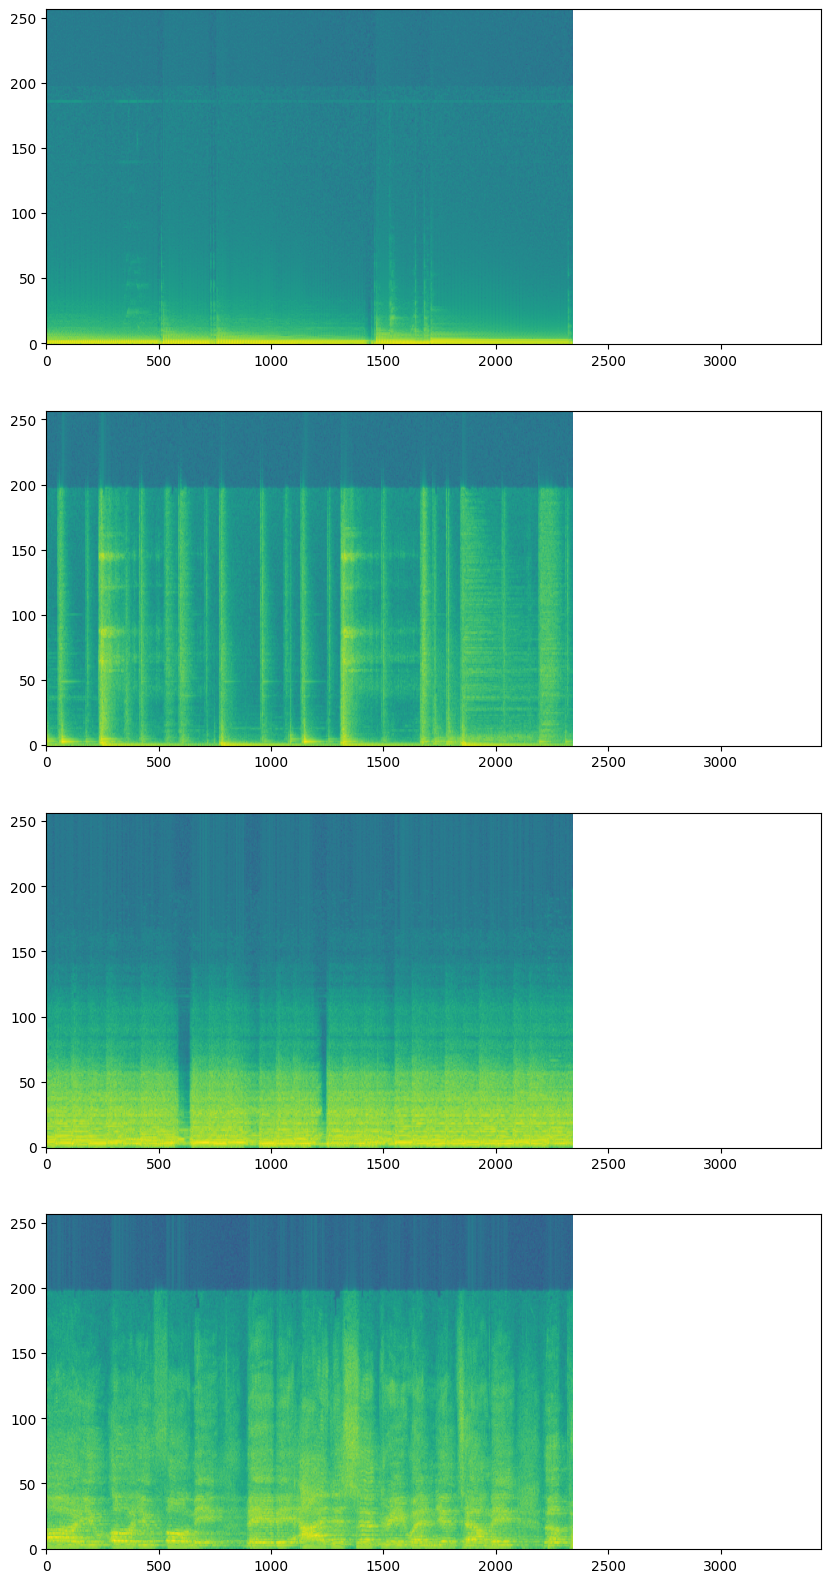

In [43]:
# Make Magnitude Spectrogram np.abs(AudioSignal.stft())
msa = nussl_tfm.MagnitudeSpectrumApproximation()

item = trainset[0]

transformed_item = msa(item)
print(transformed_item.keys())
print(transformed_item['source_magnitudes'].shape)

plt.figure(figsize=(10,20))
plt.subplot(4,1,1)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,0]), origin='lower', aspect='auto')
plt.subplot(4,1,2)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,1]), origin='lower', aspect='auto')
plt.subplot(4,1,3)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,2]), origin='lower', aspect='auto')
plt.subplot(4,1,4)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,3]), origin='lower', aspect='auto')

(257, 3447, 1, 1)


/tmp/ipykernel_485999/1974716886.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(transformed_item['source_magnitudes'].squeeze()), origin='lower', aspect='auto')


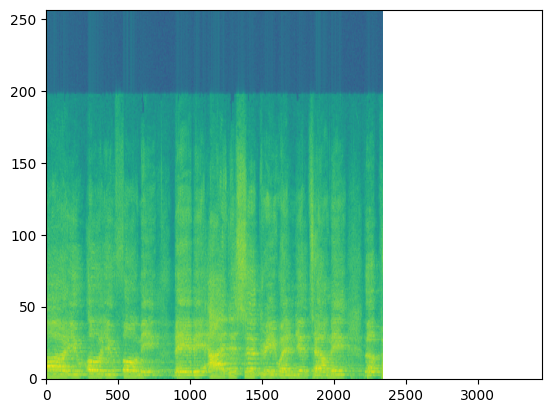

In [45]:
index_sources = nussl_tfm.IndexSources('source_magnitudes', 3)
transformed_item = index_sources(msa(item))
print(transformed_item['source_magnitudes'].shape)
plt.imshow(np.log10(transformed_item['source_magnitudes'].squeeze()), origin='lower', aspect='auto')


In [46]:
type(transformed_item['source_magnitudes'])

numpy.ndarray

In [48]:
to_tensor = nussl_tfm.ToSeparationModel()
item = trainset[0]
transformed_item = to_tensor(index_sources(msa(item)))
print(transformed_item.keys())

dict_keys(['mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


In [49]:
transformed_item['source_magnitudes'].shape

torch.Size([3447, 257, 1, 1])

In [51]:
transformed_item['mix_magnitude'].shape

torch.Size([3447, 257, 1])

In [52]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])
item = trainset[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

Before transforms
mix <class 'nussl.core.audio_signal.AudioSignal'>
sources <class 'dict'>
metadata <class 'dict'>

After transforms
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


In [53]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])
duration = 5
trainset = data.on_the_fly(stft_params, 
                          transform=tfm, 
                          fg_path=dataset_path+"/train", 
                          num_mixtures=10000000,
                          time_stretch=None,
                          duration=duration)
item = trainset[0]
print(item.keys())

dict_keys(['index', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


In [54]:
len(trainset)

10000000

In [55]:
validset = data.on_the_fly(stft_params, transform=tfm, fg_path=dataset_path+"/valid", num_mixtures=64,time_stretch=None, duration=duration)
testset = data.on_the_fly(stft_params, transform=tfm, fg_path=dataset_path+"/test", num_mixtures=32,time_stretch=None, duration=duration)

In [ ]:
stft_params.window_length

## Design Model

In [57]:
import torch
import torch.nn as nn
import torchaudio

In [91]:
class Separator(nn.Module):
  def __init__(self, num_freq,hidden_size):
    super().__init__()
    self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype='magnitude')
    self.batch_norm = nn.BatchNorm1d(num_freq)
    self.rnn = nn.LSTM(input_size=num_freq, hidden_size=hidden_size, num_layers=3, bidirectional=True, batch_first=True, dropout=0.3)
    self.linear = nn.Linear(hidden_size*2, num_freq)
    
  def forward(self, x):
    x = x.float()
    db_spec = self.amp_to_db(x)
    db_spec = db_spec[..., 0].permute(0,2,1)
    norm_spec = self.batch_norm(db_spec)
    norm_spec = norm_spec.permute(0,2,1)
    
    hidden, _ = self.rnn(norm_spec)
    mask = self.linear(hidden).sigmoid().unsqueeze(-1)
    masked_output = x.float() * mask
    
    return {'mask': mask, 'estimation': masked_output}

model = Separator(num_freq=stft_params.window_length//2+1, hidden_size=32)


In [60]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
batch = next(iter(train_loader))

In [92]:
model(batch['mix_magnitude'])

{'mask': tensor([[[[0.4587],
           [0.4729],
           [0.5180],
           ...,
           [0.5134],
           [0.4918],
           [0.4879]],
 
          [[0.4585],
           [0.4723],
           [0.5144],
           ...,
           [0.5152],
           [0.4901],
           [0.4787]],
 
          [[0.4621],
           [0.4696],
           [0.5143],
           ...,
           [0.5180],
           [0.4831],
           [0.4805]],
 
          ...,
 
          [[0.4687],
           [0.4617],
           [0.5179],
           ...,
           [0.5158],
           [0.4767],
           [0.4888]],
 
          [[0.4721],
           [0.4642],
           [0.5183],
           ...,
           [0.5161],
           [0.4772],
           [0.4906]],
 
          [[0.4723],
           [0.4698],
           [0.5163],
           ...,
           [0.5141],
           [0.4772],
           [0.4910]]],
 
 
         [[[0.4620],
           [0.4712],
           [0.5229],
           ...,
           [0.5112],
  

In [66]:
batch.keys()
batch['mix_magnitude'].shape, batch['source_magnitudes'].shape

(torch.Size([16, 1724, 257, 1]), torch.Size([16, 1724, 257, 1, 1]))

In [88]:
x = batch['mix_magnitude']
db_x = model.amp_to_db(x.float())

db_x_perm = db_x[..., 0].permute(0, 2, 1)
norm_x = model.batch_norm(db_x_perm)
norm_x_perm = norm_x.permute(0, 2, 1)

rnn_out, final_hidden = model.rnn(norm_x_perm)
linear_out = model.linear(rnn_out)
linear_out.shape
linear_out.sigmoid()

tensor([[[0.4756, 0.4821, 0.4610,  ..., 0.4748, 0.4578, 0.4538],
         [0.4783, 0.4846, 0.4627,  ..., 0.4768, 0.4625, 0.4478],
         [0.4851, 0.4823, 0.4625,  ..., 0.4780, 0.4578, 0.4517],
         ...,
         [0.4785, 0.4788, 0.4591,  ..., 0.4902, 0.4590, 0.4529],
         [0.4823, 0.4794, 0.4602,  ..., 0.4914, 0.4633, 0.4544],
         [0.4858, 0.4789, 0.4648,  ..., 0.4939, 0.4645, 0.4634]],

        [[0.4783, 0.4770, 0.4595,  ..., 0.4840, 0.4493, 0.4538],
         [0.4759, 0.4683, 0.4581,  ..., 0.4805, 0.4510, 0.4501],
         [0.4790, 0.4680, 0.4623,  ..., 0.4798, 0.4453, 0.4514],
         ...,
         [0.4863, 0.4743, 0.4515,  ..., 0.4774, 0.4632, 0.4512],
         [0.4876, 0.4685, 0.4563,  ..., 0.4770, 0.4666, 0.4594],
         [0.4842, 0.4702, 0.4637,  ..., 0.4837, 0.4699, 0.4624]],

        [[0.4831, 0.4824, 0.4537,  ..., 0.4809, 0.4472, 0.4506],
         [0.4847, 0.4761, 0.4551,  ..., 0.4779, 0.4483, 0.4483],
         [0.4844, 0.4733, 0.4589,  ..., 0.4805, 0.4519, 0.

In [ ]:
rnn_example = nn.LSTM(input_size=1, hidden_size=2, num_layers=1)

In [ ]:
input_dummy = torch.arange(12).view(1,-1,1).float()
input_dummy

In [ ]:
output, hidden_states = rnn_example(input_dummy)
output

In [ ]:
h_state, c_state = hidden_states
h_state, c_state

In [93]:
train_loader = DataLoader(trainset, shuffle=True, batch_size=16, num_workers=8)
valid_loader = DataLoader(validset, batch_size=32)
# batch = next(iter(train_loader))

In [ ]:
batch.keys()

In [ ]:
mix_spec = batch['mix_magnitude']
model(mix_spec)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch['mix_magnitude'].shape

In [95]:
self = model
x = batch['mix_magnitude']

db_spec = self.amp_to_db(x.float())
db_spec = db_spec[..., 0].permute(0,2,1)
norm_spec = self.batch_norm(db_spec)
norm_spec = norm_spec.permute(0,2,1)

hidden, _ = self.rnn(norm_spec)
mask = self.linear(hidden).sigmoid().unsqueeze(-1)
masked_output = x.float() * mask

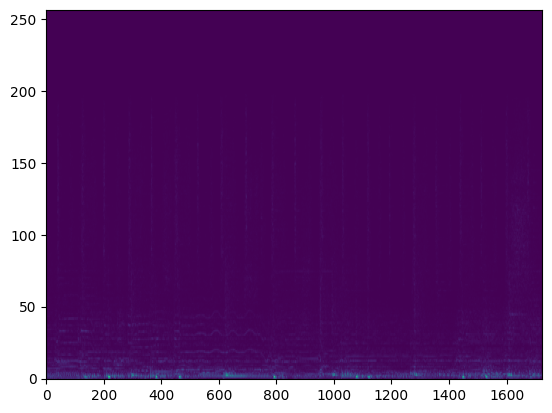

In [96]:
plt.imshow(x[0].transpose(0,1), aspect='auto', origin='lower')

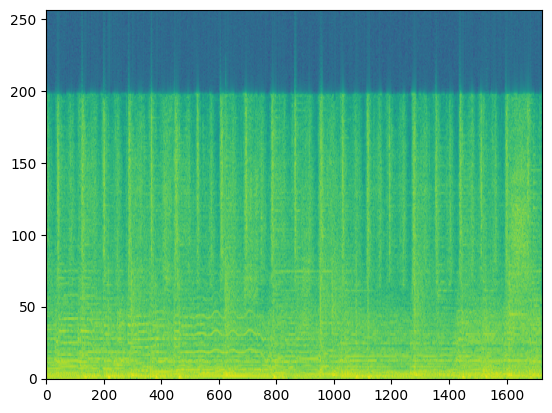

In [97]:
plt.imshow(db_spec[0], aspect='auto', origin='lower')

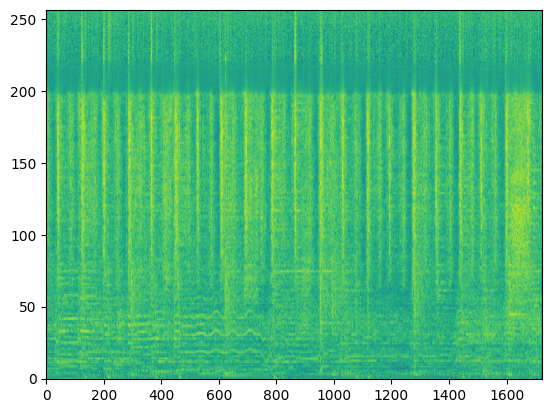

In [98]:
plt.imshow(norm_spec[0].detach().permute(1,0), aspect='auto', origin='lower')

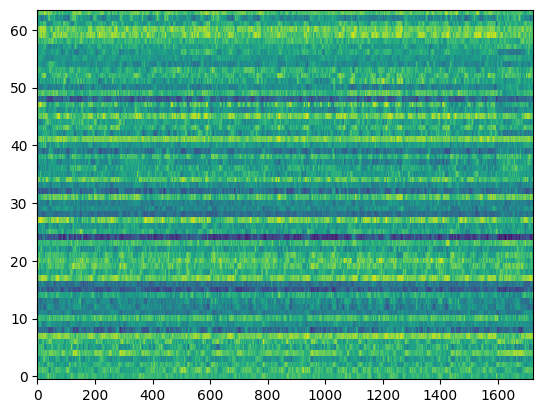

In [100]:
plt.imshow(hidden[0].detach().permute(1,0), aspect='auto', origin='lower', interpolation='none')

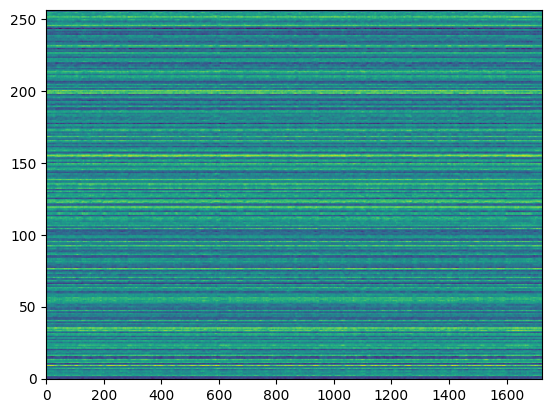

In [101]:
plt.imshow(mask[0].detach().permute(1,0,2), aspect='auto', origin='lower')

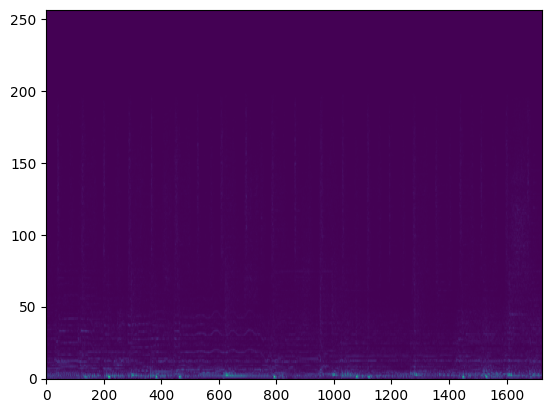

In [102]:
plt.imshow(masked_output[0].detach().permute(1,0,2), aspect='auto', origin='lower')

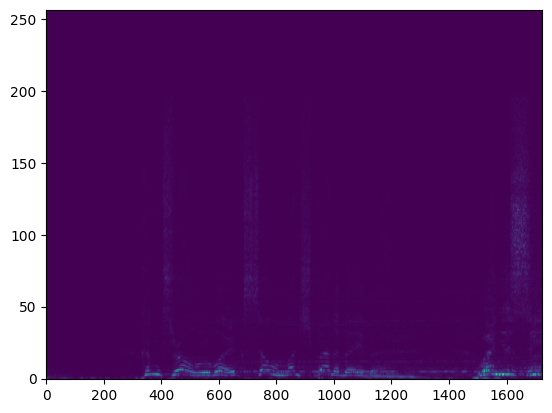

In [103]:
plt.imshow(batch['source_magnitudes'][0][...,0].transpose(0,1), aspect='auto', origin='lower')

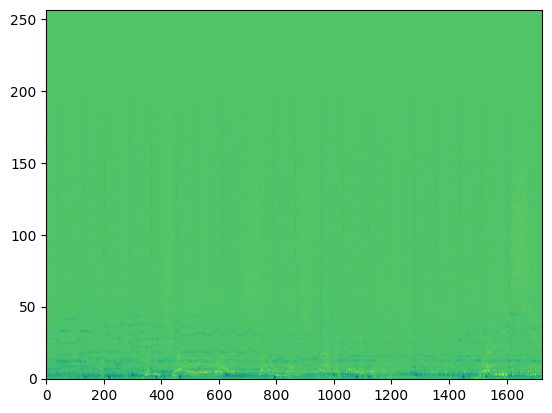

In [104]:
diff= batch['source_magnitudes'][0][...,0].transpose(0,1) - masked_output[0].detach().permute(1,0,2)
plt.imshow(diff, aspect='auto', origin='lower')

In [105]:
def spec_l1_loss(pred, target):
  return torch.mean(torch.abs(pred-target))

In [108]:
def train_loop(model, optimizer, train_loader, valid_loader, loss_func, num_iter, valid_iter, device):
  model = model.to(device)
  itr = 0
  train_loss_record = []
  valid_loss_record = []
  model.train()
  iter_train_loader = iter(train_loader)
  for itr in tqdm.tqdm(range(num_iter)):
    batch = next(iter_train_loader)
    optimizer.zero_grad()
    pred = model(batch['mix_magnitude'].to(device))
    loss = loss_func(pred['estimation'], batch['source_magnitudes'][..., 0].to(device))
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    train_loss_record.append(loss.item())
    if itr % valid_iter == 0:
      model.eval()
      valid_loss = 0
      with torch.no_grad():
        for batch in valid_loader:
          pred = model(batch['mix_magnitude'].to(device))
          loss = loss_func(pred['estimation'], batch['source_magnitudes'][..., 0].to(device))
          valid_loss = loss.item() * len(batch['mix_magnitude'])
      valid_loss_record.append(valid_loss/len(valid_loader.dataset))
      model.train()
  return {'train': train_loss_record, 'valid':valid_loss_record}

    
train_loader = DataLoader(trainset, shuffle=True, batch_size=32, num_workers=8)
valid_loader = DataLoader(validset, batch_size=32, num_workers=0)

model = Separator(num_freq=stft_params.window_length//2+1, hidden_size=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
result = train_loop(model, optimizer, train_loader, valid_loader, spec_l1_loss, 500, 50, device='cuda')
model = model.to('cpu')
torch.save(model.state_dict(), 'vocal_separator_lstm.pt')

100%|██████████| 500/500 [06:52<00:00,  1.21it/s]


In [ ]:
torch.save(model.state_dict(), 'vocal_separator_lstm.pt')

In [ ]:
ckpt = torch.load('vocal_separator_lstm_large.pt')

In [ ]:
model.load_state_dict(ckpt)

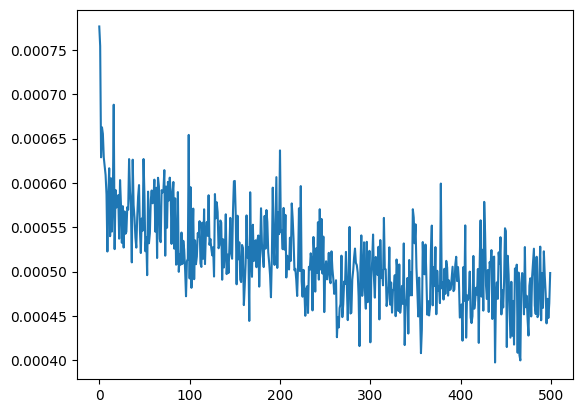

In [109]:
plt.plot(result['train'])
# plt.plot(list(range(0, 10000, 200)), result['valid'])

In [ ]:
class ConvStack(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=(kernel_size-1)//2)
    self.norm = nn.BatchNorm2d(out_channels)
    self.pool = nn.MaxPool2d((2,1))
  
  def forward(self, x):
    return self.norm(self.cnn(x)).relu()

class CnnSeparator(nn.Module):
  def __init__(self, num_freq,hidden_size):
    super().__init__()
    self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype='magnitude')
    self.batch_norm = nn.BatchNorm2d(num_freq)
    self.layer = nn.Sequential(
                                ConvStack(1, 64, 3),
                                ConvStack(64, 128, 3),
                                ConvStack(128, 256, 3),
    )
    # self.rnn = nn.LSTM(input_size=num_freq, hidden_size=hidden_size, num_layers=3, bidirectional=True, batch_first=True, dropout=0.3)
    self.linear = nn.Linear(hidden_size*2, num_freq)
    
  def forward(self, x):
    x = x.float()
    db_spec = self.amp_to_db(x)
    db_spec = db_spec[..., 0].permute(0,2,1)
    norm_spec = self.batch_norm(db_spec)
    norm_spec = norm_spec.permute(0,2,1)
    
    hidden, _ = self.rnn(norm_spec)
    mask = self.linear(hidden).sigmoid().unsqueeze(-1)
    masked_output = x.float() * mask
    
    return {'mask': mask, 'estimation': masked_output}

model = Separator(num_freq=stft_params.window_length//2+1, hidden_size=32)


In [ ]:
len(result['train'])

# 3. Test on custom audio

In [111]:
# audio_path = "01 범 내려온다_Tiger is Coming.wav"
audio_path = "/home/teo/userdata/dataset/musdb/test/Zeno - Signs.stem.mp4"
audio_signal = nussl.AudioSignal(audio_path)

audio_signal.stft_params = stft_params

/home/teo/.local/share/virtualenvs/ant5015-2023-5CFwUpZ_/lib/python3.8/site-packages/nussl/core/audio_signal.py:803: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_input, self._sample_rate = librosa.load(input_file_path,
/home/teo/.local/share/virtualenvs/ant5015-2023-5CFwUpZ_/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [112]:
spec = audio_signal.to_mono().stft()
magnitude_spec = np.abs(spec)
input_tensor = torch.Tensor(magnitude_spec).float()
input_tensor = torch.stack([input_tensor, input_tensor], dim=0).permute(0,2,1,3)
print(input_tensor.shape)
model.eval()
model.to('cuda')
with torch.no_grad():
  result = model(input_tensor.to('cuda'))

torch.Size([2, 80689, 257, 1])


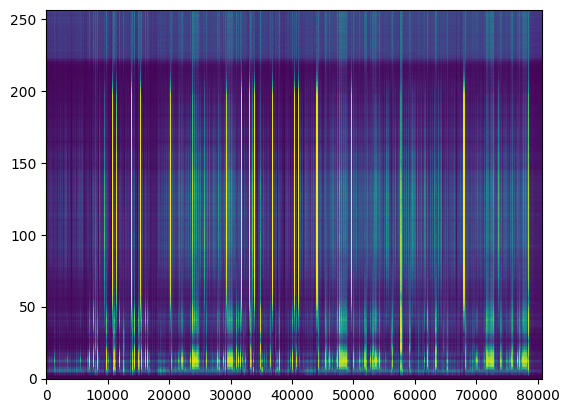

In [114]:
plt.imshow(result['mask'][0].cpu().permute(1,0,2), aspect='auto', origin='lower', interpolation='nearest')

In [115]:
masked_spec = result['estimation'][0].cpu().numpy().transpose(1,0,2)
masked_spec = masked_spec* np.exp(1j * np.angle(spec))

print(masked_spec.shape)
recon_signal = nussl.AudioSignal(stft=masked_spec, sample_rate=audio_signal.sample_rate, stft_params=stft_params)
recon_audio = recon_signal.istft()

(257, 80689, 1)


In [ ]:
display(Audio(recon_audio, rate=recon_signal.sample_rate))

In [ ]:
mix_spec = batch['mix_magnitude']
mix_spec = torchaudio.transforms.AmplitudeToDB()(mix_spec)
print(mix_spec.shape) # N T F C
mix_spec = mix_spec.permute(0,2,1,3) # N F T C
nn.BatchNorm2d(257)(mix_spec)

In [ ]:
batch['source_magnitudes'].shape